# Overview of RSRM


Let $N$ be the number of subjects, $v$ the number of features, $k$ the number of latent components, and $t$ the number of time-points.

The following expression is the primary equation for the Robust Shared-Response model

\begin{equation}\tag{1}
\mathbf{X}^{(i)} = \mathbf{W}^{(i)}\mathbf{R} + \mathbf{S}^{(i)} + \mathbf{E}^{(i)},\ i = 1 \dots N
\end{equation}

where $(i)$ is the indexer for each individual subject.

### **Variables**

- $\mathbf{X}^{(i)} \in \mathbb{R}^{v_i×t}$ is the data matrix, 

- $\mathbf{W}^{(i)} \in \mathbb{R}^{v_i×k}$ is the matrix mapping from the observed subject space to the shared latent space, 

- $\mathbf{R} \in \mathbb{R}^{k×t}$ is the shared-response matrix, 

- $\mathbf{S}^{(i)} \in \mathbb{R}^{v_i×t}$ is the non-shared matrix unique to each individual subject, and 

- $\mathbf{E}^{(i)} \in \mathbb{R}^{v_i×t}$ is an additive noise matrix specific for each subject.



### **Additional Parameters**
**Lambda** ($\lambda$)

The shrinkage parameter $\lambda$ balances how much is thought to be shared  ($\mathbf{R}$) by each subject and how much is unique to each subject ($\mathbf{S}^{(i)}$). As $\lambda \rightarrow \infty$, the model is equivalent to the deterministic solution where $\mathbf{S}^{(i)}\rightarrow 0$. As $\lambda \rightarrow 0$, there will be no shared response between individuals and all portions are unique to each individual. In other words $\mathbf{S}^{(i)}\rightarrow \mathbf{X}^{(i)}$.

**Number of Components** $\text{(n_components)}$

The n_components parameter sets the number of components we want our model to compute. This is algorithm is partially inspired by robust principal component analysis. 



### **Optimization Problem**
Equation (1) is then estimated by solving the following optimization problem

\begin{equation}\tag{2}
\min\limits_{\mathbf{S}^{(i)}, \mathbf{W}^{(i)}, \mathbf{R}}  \sum_{i=1}^{N} \frac{1}{2} ||\mathbf{X}^{(i)} - \mathbf{W}^{(i)}\mathbf{R} - \mathbf{S}^{(i)}||^2_F + \lambda_i||\mathbf{S}^{(i)}||_1\\
\text{s.t.}\ \mathbf{W}^{(i)^T}\mathbf{W}^{(i)} = \mathbf{I}, \ \ \forall i = 1 \dots N
\end{equation}

Equation (2) is a non-convex optimization problem, but we can use a greedy approach to estimate subsets of the model and combine the results at the end. Using Block Coordinate Descent, we can partition the variables into blocks and optimize each block while fixing the other blocks constant. In RSRM, each individual mapping from the latent space $\mathbf{W}^{(i)}$, each individual non-shared/unique matrix $\mathbf{S}^{(i)}$, and the shared response model $\mathbf{R}$ is a block. Because optimizing each of these blocks while keeping the other blocks constant is a convex problem, we can approximate the global optimum with a greedy solution. 



### **Algorithm's Process**
The derivations of $\mathbf{R}$, $\mathbf{W}^{(i)}$, and $\mathbf{S}^{(i)}$, will be provided above the functions in which they are used. Here we will discuss the broader process of the algorithm. 

The algorithms main process iterates these three steps. 

**(1) Solve for $\mathbf{W}^{(i)}$ with Procrustes:** 
<br />
\begin{equation}\tag{3}
\mathbf{W}^{(i)} = \mathbf{U}^{(i)}\mathbf{V}^{(i)^T}
\end{equation}
<br />
Where, $\mathbf{U}^{(i)}\mathbf{V}^{(i)^T}$ is achieved through the singular value decomposition of: 
<br />
<br />
\begin{equation}\tag{4}
\mathbf{U}^{(i)}\mathbf{\Sigma}^{(i)}\mathbf{V}^{(i)} = ( (\mathbf{X}^{(i)} - \mathbf{S}^{(i)} ) \mathbf{R}^T )
\end{equation}
<br />
<br />

**(2) Solve for $\mathbf{S}^{(i)}$ with Soft Shrinkage:**
<br />
\begin{equation}\tag{5}
\mathbf{S}^{(i)}=\text{Shrink(}\mathbf{X}^{(i)}-\mathbf{W}^{(i)}\mathbf{R},   \lambda)
\end{equation}
<br />
Where the amount of shrinkage is determined by $\lambda$. 
<br />
<br />
<br />
<br />
**(3) Solve for $\mathbf{R}$:**
<br />
\begin{equation}\tag{6}
\mathbf{R} = \frac{1}{N} \sum_{i=1}^{N}
\mathbf{W}^{(i)^T}(\mathbf{X}^{(i)}-\mathbf{S}^{(i)})
\end{equation}
<br />
<br />
Generally, the optimum can be achieved with a relatively low number of iterations which is ideal since we want to be able to update the shared response quickly if we gather more data.



# Main Loop
The main optimization function for computing $\mathbf{R}$, $\mathbf{S}^{(i)}$, and $\mathbf{W}^{(i)}$. 

## Check if Time Points are the Same Length for Each Subject
The first action we take is checking if every matrix in $\mathbf{X}$ has the same number of timepoints; this is equivalent to the number of columns. If the number of time points differ, an error will be thrown. 

## Extract Constants
Next, we calculate the number of subjects we have by taking the length of the list, $\mathbf{X}^{(i)}$; then we extract the number the features by counting the number of rows in each subject matrix in $\mathbf{X}^{(i)}$; and then we grab the number of time points by counting the columns for a single subject in $\mathbf{X}^{(i)}$. These three values are held constant throughout the algorithm.

## Initialize Parameters
$\mathbf{W}^{(i)}$ is initialized by init_transforms, which returns N, features by components, orthogonal matrices. The values within $\mathbf{W}^{(i)}$ are drawn froma normal random distribution. $\mathbf{S}^{(i)}$ is initialized as a series of N empty matrices of shape, components by timepoints. $\mathbf{R}$ is initialized with the update_shared_response function which returns the shared response as a function of $\mathbf{X}^{(i)},\mathbf{S}^{(i)}, \text{and} \ \mathbf{W}^{(i)}$. The shared response has the shape, components by timepoints. 

We then return $\mathbf{R},\mathbf{S}^{(i)}, \text{and} \ \mathbf{W}^{(i)}$


We will go into greater depth for each of these initializations before the cells of each of the functions they call. 

# Primary Robust Shared Response Model routine

In [3]:
# Primary Robust Shared Response Model routine
rsrm <- function(X, n_components, lambda = 1, iter = 10){
  
  # Each input matrix must have equal number of time points
  if(var(sapply(X, ncol)) != 0){
    stop("All subjects must have the same number of time points")
  }
  
  # Number of subjects
  subjs <- length(X)
  
  # Number of features for each subject
  features <- sapply(X, nrow)
  
  # Extract number of time points
  n_time <- ncol(X[[1]])
  
  # Initialize W (mapping) matrices
  W <- init_transforms(subjs, features, n_components)
  # Initialize S (subject) matrices
  S <- init_individual(subjs, features, n_time)
  # Initialize R (shared-response)
  R <- update_shared_response(X, S, W, n_components)
  
  # Block-Coordinate Descent
  for(i in 1:iter){
    
    # Solve for W (mapping) matrices
    W <- update_transforms(X, S, R)
    # Solve for S (subject) matrices
    S <- update_individual(X, W, R, lambda)
    # Solve for R (shared-response) matrix
    R <- update_shared_response(X, S, W, n_components)
    
  }
  # Store RSRM results
  return(list("R" = R, "S" = S, "W" = W))
}

# QR Decomposition to Initialize (W)

This algorithm uses QR decomposition which takes a matrix $\mathbf{A}$ and factors it into into the product $\mathbf{A}=\mathbf{QR}$ where $\mathbf{Q}$ is an orthogonal matrix and $\mathbf{R}$ is an upper right triangle matrix. QR decomposition can be used to efficiently solve the Linear Least Squares problem and can also be used to solve for eigenvalues and eigenvectors of a matrix. However, in the context of the RSRM algorithm it is only used to find a random orthogonal matrix to serve as a starting point for the weights matrix $\mathbf{W}^{(i)}$.

In [4]:
init_transforms <- function(subjs, features, n_components){
  # Initialize W (mapping) matrix list
  W <- base::vector(mode = "list", length = subjs)

  for(i in 1:subjs){
    # Initialize W (mapping) matrices
    W[[i]] <- matrix(rnorm(features * n_components), 
                         nrow = features, 
                         ncol = n_components)
  
    # Find orthogonal matrix to W with QR
    W[[i]] <- qr.Q(qr(W[[i]]))
  }
  return(W)
}

# Initializing Unshared Components (S)
Here we initialize $\mathbf{S}^{(i)} \in \mathbb{R}^{m \times n}$ (features by time) with each element of $\mathbf{S}^{(i)}$ set to 0.

In [5]:
init_individual <- function(subjs, features, n_time){
  # Initialize S matrix list
  S <- base::vector(mode = "list", length = subjs)
  for(i in 1:subjs){
    # Initialize S (subject) matrix
    S[[i]] <- matrix(0, nrow = features[i], 
                      ncol = n_time)
  }
  return(S)
}

# Update Shared Response (R)

Here we derive $\mathbf{R}$
\begin{align}
\mathbf{X}^{(i)} &= \mathbf{W}^{(i)}\mathbf{R} + \mathbf{S}^{(i)} \\

\mathbf{W}^{(i)}\mathbf{R} &= \mathbf{X}^{(i)} - \mathbf{S}^{(i)} \\

\mathbf{W}^{(i)^T} \mathbf{W}^{(i)}\mathbf{R} &= \mathbf{W}^{(i)^T} (\mathbf{X}^{(i)} - \mathbf{S}^{(i)})

\end{align}

and since $\mathbf{W}^{(i)}$ is Orthogonal, $\mathbf{W}^{(i)^T} \mathbf{W}^{(i)} = \mathbf{I}$

$$\mathbf{R} = \mathbf{W}^{(i)^T}(\mathbf{X}^{(i)}-\mathbf{S}^{(i)})$$
which provides the following solution
\begin{equation}\tag{6}
\mathbf{R} = \frac{1}{N} \sum_{i=1}^{N}
\mathbf{W}^{(i)^T}(\mathbf{X}^{(i)}-\mathbf{S}^{(i)})
\end{equation}

This returns a components by time shared response matrix. This step is used both in the initialization of $\mathbf{R}$, and in the main optimization loop. Notice that there is only one $\mathbf{R}$ matrix. This is because it represents what is shared amongst all subjects.



In [6]:
update_shared_response <- function(X, S, W, n_components){
  
  # Number of subjects
  subjs <- length(X)
  
  # Number of time points
  n_time <- ncol(X[[1]])
  
  # Initialize R matrix
  R <- matrix(0, nrow = n_components, 
                 ncol = n_time)
  
  # Update R
  for(i in 1:subjs){
    R <- R + t(W[[i]]) %*% (X[[i]] - S[[i]])
  }
  
  # Scale down R by number of subjects
  R <- R / subjs
  return(R)
}

# Solve for the Mapping (W)

Here we going to solve for $\mathbf{W}^{(i)}$
$$\mathbf{X}^{(i)} = \mathbf{W}^{(i)}\mathbf{R} + \mathbf{S}^{(i)}$$
$$\mathbf{W}^{(i)}\mathbf{R} =\mathbf{X}^{(i)} - \mathbf{S}^{(i)}$$
Since R is a singular matrix there is no basic operation to solve for $\mathbf{W}^{(i)}$. This is what is classed the Procrustes problem looking for the orthogonal matrix $\mathbf{W}^{(i)}$ which most closely maps $\mathbf{R}$ onto $(\mathbf{X}^{(i)} - \mathbf{S}^{(i)})$. This problem has a closed form solution using Singular Value Decomposition.
Singlar Value Decomposition (SVD) is a widely used factorization of a matrix $\mathbf{M}=\mathbf{U \Sigma V}^T$ where $\mathbf{U}$ and $\mathbf{V}$ are the left and right Unitary Matrices of $\mathbf{M}$ and $\mathbf{\Sigma}$ is a rectangular diagonal matrix consisting of the singular values. SVD is used in principal component analysis, signal processes, as well as finding pseudo-inverses, but here we are going to use it to find the nearest orthogonal matrix $\mathbf{O}$ to matrix $\mathbf{M}$ using the Frobenius norm. The solution to this problem is $\mathbf{O} = \mathbf{UV}^T$ where $\mathbf{M}=\mathbf{U \Sigma V}^T$ which amounts to replacing $\mathbf{\Sigma}$ with an identity matrix $\mathbf{I}$.

Similarly when trying to find the nearest orthogonal matrix $\mathbf{O}$ which maps $\mathbf{A}$ onto $\mathbf{B}$ defined by
$$\mathbf{O} = \underset{\Omega}{\arg\min}||\mathbf{A\Omega-B}||_F \: \: \: s.t.  \:\: \mathbf{\Omega} ^T\mathbf{ \Omega}=\mathbf{I}$$
is equivalent to finding the nearest orthogonal matrix to $\mathbf{M}=\mathbf{A}^T\mathbf{B}$.
Coming back to our problem we set $\mathbf{M}=( (\mathbf{X}^{(i)} - \mathbf{S}^{(i)} ) \mathbf{R}^T )$ and factor it to
$$\mathbf{U}^{(i)} \mathbf{\Sigma}^{(i)}\mathbf{V}^{(i)} = ( (\mathbf{X}^{(i)} - \mathbf{S}^{(i)} ) \mathbf{R}^T )$$
so then we can solve for the orthogonal matrix $\mathbf{W}^{(i)}$ by
$$\mathbf{W}^{(i)} = \mathbf{U}^{(i)}\mathbf{V}^{(i)^T}$$

In [8]:
update_transforms <- function(X, S, R){
  
  # Number of subjects
  subjs <- length(X)
  
  # Initialize W (mapping) matrix list
  W <- base::vector(mode = "list", length = subjs)
  
  for(i in 1:subjs){
    
    A <- X[[i]] %*% t(R)
    A <- A - S[[i]] %*% t(R)
    
    # Singular Value Decomposition
    svd_res <- svd(A)
    # Solution to the Procrustes problem
    W[[i]] <- svd_res$u %*% t(svd_res$v)
  }
  return(W)
}

# Solve for Unshared Components (S)
Soft shrinkage function is applied to the individual residual $\mathbf{D}^{(i)}$, where:
$$\mathbf{D}^{(i)}=\mathbf{X}^{(i)}-\mathbf{W}^{(i)}\mathbf{R}$$ and the soft shrinkage of $\mathbf{D}^{(i)}$ is equal to $\mathbf{S}^{(i)}$



In [9]:
update_individual <- function(X, W, R, lambda){
  
  # Number of subjects
  subjs <- length(X)
  
  # Initialize S (subject) matrix list
  S <- base::vector(mode = "list", length = subjs)
  
  # Compute regularized S (subject) matrices
  for(i in 1:subjs){
    S[[i]] <- shrink(X[[i]] - W[[i]] %*% R, lambda)
  }
  return(S)
}

# Soft Shrinkage

Soft shrinkage is applied to $\mathbf{D}^{(i)}$ 

$$s = S_{\lambda_i}(d) =
\begin{cases} 
(|d|-\lambda_i)\text{sign}(d), & \text{if}\ |d| > \lambda_i \\
0 & \text{otherwise.} 
\end{cases}$$

Note that the *pos* and *neg* objects in the cell below are Boolean matrices that index into $\mathbf{D}^{(i)}$ to determine the correct shrinkage application.

In [10]:
shrink <- function(D, lambda){
  
  # Find absolute values greater than lambda
  pos <- D > lambda
  neg <- D < -lambda
  
  # Penalize large absolute values by lambda
  D[pos] <- D[pos] - lambda
  D[neg] <- D[neg] +  lambda

  # Assign all other values to 0
  D[!pos & !neg] <- 0
  return(D)
}

# Simulate Data

RSRM can be classified as an unsupervised learning problem. In this way, there is no way to predict with certainty what the patterns *should*  look like when applied to naturalistic signals with unknown parameters. In order to get an intuitive sense that our RSRM implementation is working properly, we can simulate data with known parameters and attempt to recover them through visualization of the latent shared space. Sine-waves with specific frequencies $f$, or speed of oscillations, are a good candidate for simulating time-series signals. Remember that this implementation of RSRM is *greedy*, and there are no guarantees that it will return the globally optimal solution. For this approach, we are expecting output that is intuitive and that matches our prior expectation, rather than searching for a specific point estimate for $f$. This is because multiple signals will likely be embedded into the same latent space and will not be perfectly separated.

Let $A$ be amplitude, $\theta$ phase angle offset, $\mathbf{t} \in \mathbb{R}^n$ time. Sine-waves can be generated with the expression

$$A \sin(2\pi f \mathbf{t} + \theta)$$

Note that if $A = 1$ and $\theta = 0$, then the standard sine wave can be simplified to 

$$\sin(2\pi f\mathbf{t})$$
We can perturb this signal by adding Gaussian noise generated by $N \sim (\mu, \sigma)$, and attempt to recover all instances of $f$ in the latent shared response space.



In [12]:
# Simulation parameters
n_time <- 1000 # number of time points
n_feat <- 100 # number of features
n_subj <- 100 # number of subjects
mu <- 0 # Gaussian mu
sigma <- 2 # Gaussian sd

# Generate a sine wave
sine_wave <- function(freq, srate, amp = 1){

  # Get the time series vector
  time <- seq(0, 1 - (1 / srate), 1 / srate)
  # Compute the sine-wave
  sin_wave <-  amp * sin(2 * pi * freq * time)
  return(sin_wave)
}

In [14]:
# Initialize signal and noise matrices
sim_res <- base::vector(mode = "list", length = n_subj)
noise <- sim_res

# Specify frequency family
freq_fam <- c(7, 12, 25)

for(i in 1:n_subj){
  # Generate signals from frequency family
  sim_res[[i]] <- matrix(
    sine_wave(freq = sample(freq_fam, 1), 
             srate = n_time), 
    nrow = n_feat, 
    ncol = n_time, 
    byrow = TRUE
    )
  # Generate noise
  noise[[i]] <- matrix(
    rnorm(n_feat * n_time), 
    nrow = n_feat, 
    ncol = n_time)
  # Add noise to signals
  sim_res[[i]] <- sim_res[[i]] + noise[[i]]
}

# Run RSRM on simulated data
rsrm_out <- rsrm(X = sim_res, n_components = 9, lambda = 1)



# Visualizing RSRM components



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



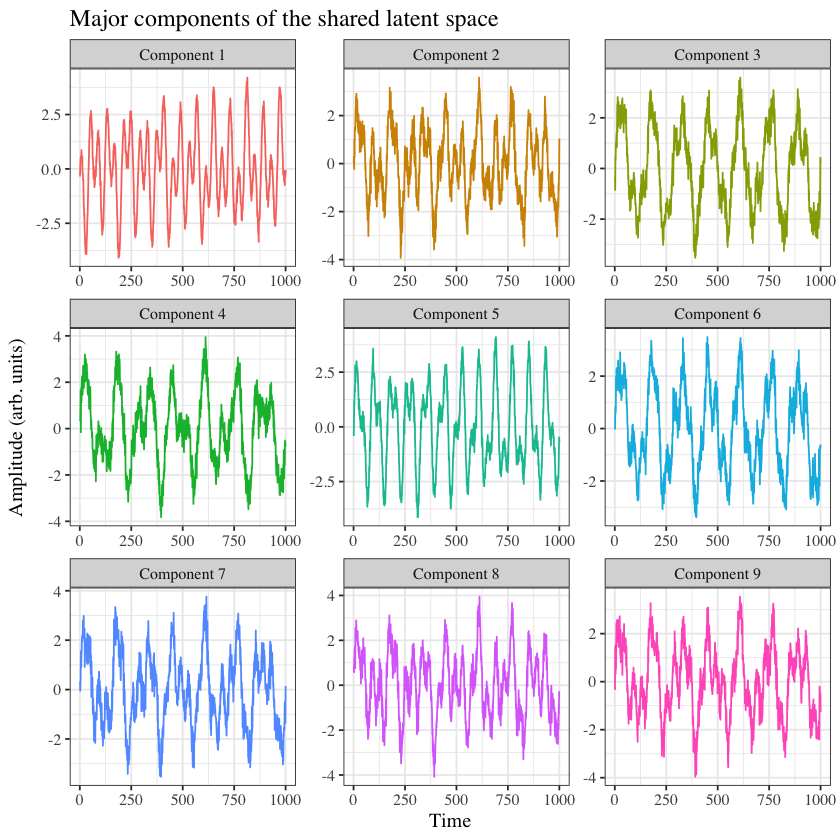

In [15]:

library(tidyverse)

# Set plot themes
theme_set(theme_bw())
theme_update(text = element_text(family = "serif", size = 12))

# Get data for plot
plot_dat <- rsrm_out$R %>%
  t() %>%
  data.frame()

# Name the columns
colnames(plot_dat) <- paste("Component", 1:9)

# Plot the data
plot_dat %>%
  bind_cols("Time" = 1:n_time) %>%
  pivot_longer(-Time) %>% 
  ggplot(aes(x = Time, y = value, color = name)) +
  geom_line() + 
  facet_wrap(~name, scales = "free") + 
  labs(y = "Amplitude (arb. units)",
       title = "Major components of the shared latent space") +
  theme(legend.position = "none")